In [1]:
# # Decode-only script for your VAE (no input normalization)

# # 1) Mount Drive (Colab only)
# from google.colab import drive
# drive.mount('/content/drive')


In [ ]:
####### TRAINS A VAE ON MNIST DIGITS #############

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torchvision.utils import save_image
from torch.utils.data import Subset
import matplotlib.pyplot as plt


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the digits to train on
digits_to_train = [1, 2, 3, 4, 5, 6, 7, 8, 9]

# Function to filter the dataset
def filter_dataset(dataset, digits_to_train):
    indices = [i for i, (img, label) in enumerate(dataset) if label in digits_to_train]
    return Subset(dataset, indices)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Filter the datasets to include only the specified digits
trainset = filter_dataset(trainset, digits_to_train)
testset = filter_dataset(testset, digits_to_train)

batch_size = 32
trainloader = torch.utils.data.DataLoader(trainset, shuffle=True, batch_size=batch_size)
testloader = torch.utils.data.DataLoader(testset, shuffle=True, batch_size=batch_size)

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        # Encoder
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc21 = nn.Linear(128, 8)  # mu
        self.fc22 = nn.Linear(128, 8)  # sigma

        # Decoder
        self.fc3 = nn.Linear(8, 128)
        self.fc4 = nn.Linear(128, 64 * 7 * 7)
        self.deconv1 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.deconv2 = nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1)

    def encoder(self, x):
        h = torch.relu(self.conv1(x))
        h = torch.relu(self.conv2(h))
        h = h.view(-1, 64 * 7 * 7)
        h = torch.relu(self.fc1(h))
        return self.fc21(h), self.fc22(h)  # mu, std

    def sampling(self, mu, std):
        eps1 = torch.randn_like(std)
        eps2 = torch.randn_like(std)
        return 0.5 * ((eps1 * std + mu) + (eps2 * std + mu))

    def decoder(self, z):
        h = torch.tanh(self.fc3(z))
        h = torch.relu(self.fc4(h))
        h = h.view(-1, 64, 7, 7)
        h = F.relu(self.deconv1(h))
        return torch.sigmoid(self.deconv2(h))

    def forward(self, x):
        mu, std = self.encoder(x)
        z = self.sampling(mu, std)
        return self.decoder(z), mu, std

model = VAE().to(device)

# Load the previously trained model
#model.load_state_dict(torch.load('/content/drive/MyDrive/vae_mnist_digits_continued.pth'))

optimizer = torch.optim.Adam(model.parameters(), lr=0.002)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5,
                             patience=5, threshold=0.001, cooldown=0,
                             min_lr=0.0001)

def loss_function(y, x, mu, std):
    x = (x + 1) / 2  # Rescale x to be in the range [0, 1]
    x = torch.clamp(x, 0, 1)
    ERR = F.binary_cross_entropy(y.view(-1, 784), x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + torch.log(std**2) - mu**2 - std**2)
    return ERR + KLD, ERR, KLD

# Specify the number of additional trials
additional_trials = 20

err_l, kld_l, n_wu, testl, update = [], [], [], [], []
count = 0

for epoch in range(1, additional_trials + 1):
    train_loss = 0
    for batch_idx, (data, _) in enumerate(trainloader):
        model.train()
        data = data.to(device)
        bsize = data.shape[0]
        recon_batch, mu, std = model(data)
        loss, err, kld = loss_function(recon_batch, data, mu, std)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        err_l.append(err.item() / bsize)
        kld_l.append(kld.item() / bsize)
        count += 1
        n_wu.append(count)

        if count % 100 == 0:  # Validating every 100 weight updates
            model.eval()
            a, _ = next(iter(testloader))
            a = a.to(device)
            trecon, tmu, tstd = model(a)
            tloss, terr, tkld = loss_function(trecon, a, tmu, tstd)
            testl.append(terr.item() / 100)
            update.append(count)

    scheduler.step(train_loss / len(trainloader.dataset))

    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(trainloader.dataset)))
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, _ in testloader:
            data = data.to(device)
            recon, mu, std = model(data)
            loss, err, kld = loss_function(recon, data, mu, std)
            test_loss += loss.item()

    test_loss /= len(testloader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

# Save the model again
torch.save(model.state_dict(), './models/vae_mnist_digits_continued.pth')

====> Epoch: 1 Average loss: 462.4124
====> Test set loss: 453.9657
====> Epoch: 2 Average loss: 454.1497
====> Test set loss: 451.4523
====> Epoch: 3 Average loss: 452.6185
====> Test set loss: 450.8093
====> Epoch: 4 Average loss: 451.7961
====> Test set loss: 450.1928
====> Epoch: 5 Average loss: 451.1673
====> Test set loss: 449.7107
====> Epoch: 6 Average loss: 450.6602
====> Test set loss: 449.3989
====> Epoch: 7 Average loss: 450.2634
====> Test set loss: 448.9694
====> Epoch: 8 Average loss: 449.9426
====> Test set loss: 448.8892
====> Epoch: 9 Average loss: 449.6808
====> Test set loss: 448.3235
====> Epoch: 10 Average loss: 449.4826
====> Test set loss: 448.4619
====> Epoch: 11 Average loss: 449.2400
====> Test set loss: 448.3577
====> Epoch: 12 Average loss: 449.0702
====> Test set loss: 448.4916
====> Epoch: 13 Average loss: 448.9167
====> Test set loss: 448.1393
====> Epoch: 14 Average loss: 448.7810
====> Test set loss: 447.9579
====> Epoch: 15 Average loss: 448.6451
====

latent vector: tensor([[-1.0179, -1.7655, -0.8316,  2.2922,  0.1551, -0.5846, -0.4402,  0.1713]],
       device='cuda:0', grad_fn=<MulBackward0>)
latent vector: tensor([[-1.0544,  1.6179,  1.0374, -1.2555,  0.5357,  1.1888,  0.8233, -0.1396]],
       device='cuda:0', grad_fn=<MulBackward0>)
latent vector: tensor([[-1.3114, -0.6867, -0.0358, -0.3500,  0.7649, -1.3375, -0.6905, -1.5787]],
       device='cuda:0', grad_fn=<MulBackward0>)
latent vector: tensor([[-0.2752,  0.4788,  0.8909,  1.3701,  0.9720,  1.0209, -0.1943,  0.2400]],
       device='cuda:0', grad_fn=<MulBackward0>)
latent vector: tensor([[ 0.4915,  0.6532, -2.3079, -0.6365,  0.9475, -0.2778,  2.0035, -2.1439]],
       device='cuda:0', grad_fn=<MulBackward0>)
latent vector: tensor([[ 1.6951,  0.0959, -1.0124, -0.1394,  0.7322,  0.7200, -0.4947,  0.8925]],
       device='cuda:0', grad_fn=<MulBackward0>)
latent vector: tensor([[ 0.2882, -1.1595, -3.2095, -0.2715,  0.3884,  2.4699, -0.6044, -0.3863]],
       device='cuda:0', gr

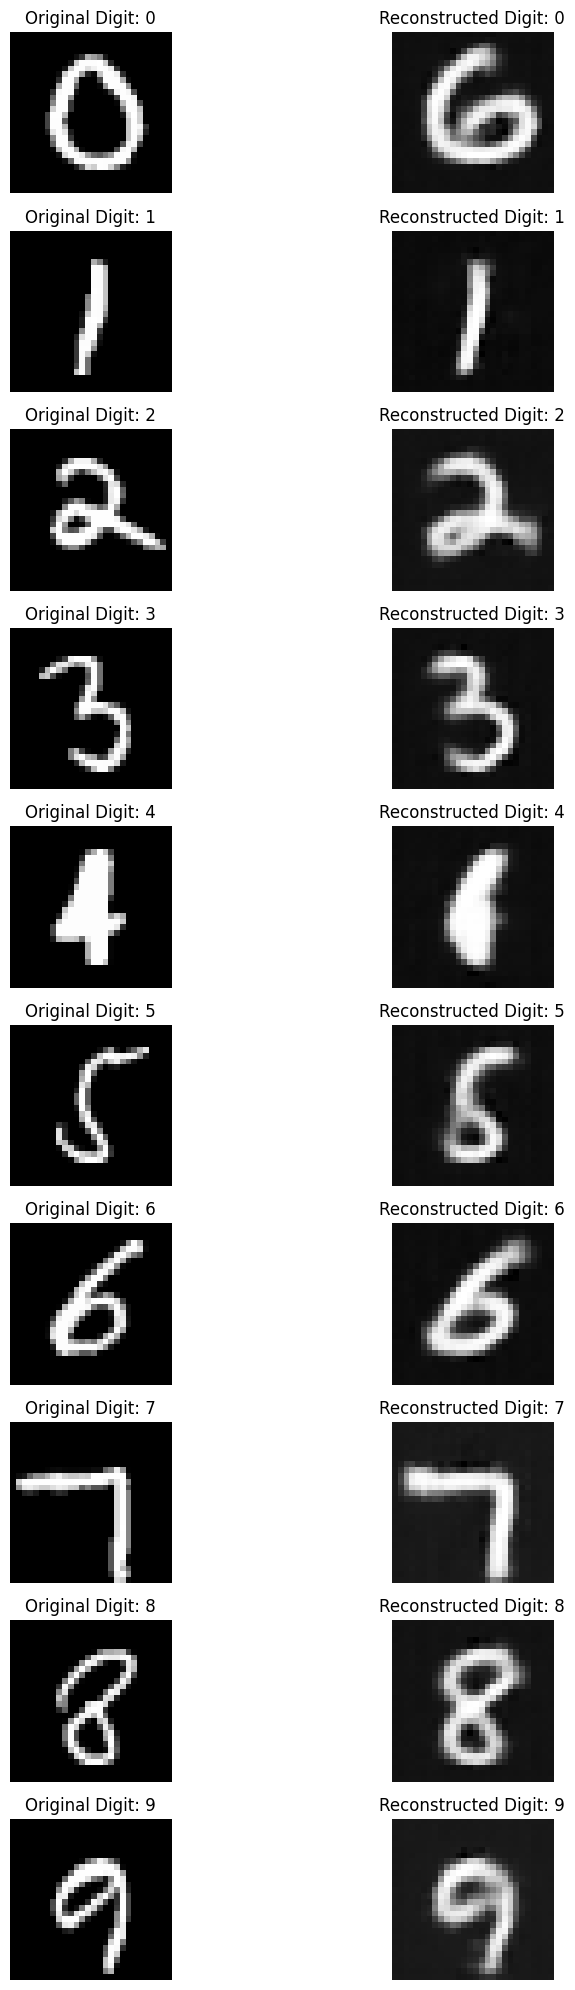

In [11]:
############ TESTS VAE RECONSTRUCTION ON RANDOMLY CHOSEN TEST DIGITS FROM EACH CLASS ###########

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the VAE architecture
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        # Encoder
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc21 = nn.Linear(128, 8)  # mu
        self.fc22 = nn.Linear(128, 8)  # sigma

        # Decoder
        self.fc3 = nn.Linear(8, 128)
        self.fc4 = nn.Linear(128, 64 * 7 * 7)
        self.deconv1 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.deconv2 = nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1)

    def encoder(self, x):
        h = torch.relu(self.conv1(x))
        h = torch.relu(self.conv2(h))
        h = h.view(-1, 64 * 7 * 7)
        h = torch.relu(self.fc1(h))
        return self.fc21(h), self.fc22(h)  # mu, std

    def sampling(self, mu, std):
        eps1 = torch.randn_like(std)
        eps2 = torch.randn_like(std)
        return 0.5 * ((eps1 * std + mu) + (eps2 * std + mu))

    def decoder(self, z):
        h = torch.tanh(self.fc3(z))
        h = torch.relu(self.fc4(h))
        h = h.view(-1, 64, 7, 7)
        h = F.relu(self.deconv1(h))
        return torch.sigmoid(self.deconv2(h))

    def forward(self, x):
        mu, std = self.encoder(x)
        z = self.sampling(mu, std)
        return self.decoder(z), mu, std

# Load the trained model
model = VAE().to(device)
model.load_state_dict(torch.load('./models/vae_mnist_digits_continued.pth', map_location=device))
model.eval()

# Load and preprocess the MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, shuffle=True, batch_size=1)

# Randomly choose one example of each digit (0-9) from the MNIST test set
selected_examples = {}
for data, target in testloader:
    label = target.item()
    if label not in selected_examples:
        selected_examples[label] = data
    if len(selected_examples) == 10:
        break

# Plot each selected digit beside the model's reconstruction of it
fig, axes = plt.subplots(10, 2, figsize=(10, 20))
for i in range(10):
    original = selected_examples[i].to(device)
    reconstruction, _, _ = model(original)
    mu, std = model.encoder(original)
    z = model.sampling(mu, std)
    print(f"latent vector: {z}")

    axes[i, 0].imshow(original.cpu().squeeze().numpy(), cmap='gray')
    axes[i, 0].set_title(f'Original Digit: {i}')
    axes[i, 0].axis('off')

    axes[i, 1].imshow(reconstruction.cpu().detach().squeeze().numpy(), cmap='gray')
    axes[i, 1].set_title(f'Reconstructed Digit: {i}')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

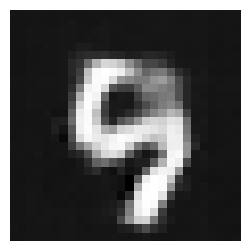

In [12]:
# Decode-only script for your VAE (no input normalization)

# 1) Mount Drive (Colab only)

# 2) Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

# 3) VAE class (must match your saved model)
class VAE(nn.Module):
    def __init__(self, zdim=8):
        super().__init__()
        # Encoder (not used here, but required for loading)
        self.conv1 = nn.Conv2d(1,32,3,2,1)
        self.conv2 = nn.Conv2d(32,64,3,2,1)
        self.fc1   = nn.Linear(64*7*7,128)
        self.fc21 = nn.Linear(128,zdim)
        self.fc22 = nn.Linear(128,zdim)
        # Decoder
        self.fc3 = nn.Linear(zdim,128)
        self.fc4 = nn.Linear(128,64*7*7)
        self.deconv1 = nn.ConvTranspose2d(64,32,3,2,1,output_padding=1)
        self.deconv2 = nn.ConvTranspose2d(32,1,3,2,1,output_padding=1)

    def sampling(self, mu, std):
        eps = torch.randn_like(std)
        return mu + eps*std

    def decoder(self, z):
        h = F.relu(self.fc3(z))
        h = F.relu(self.fc4(h))
        h = h.view(-1,64,7,7)
        h = F.relu(self.deconv1(h))
        return torch.sigmoid(self.deconv2(h))

# 4) Load model weights
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VAE().to(device)
model.load_state_dict(torch.load(
    './models/vae_mnist_digits_continued.pth',
    map_location=device))
model.eval()

# 5) Prompt for latent vector
zdim = 8
s = input(f"Enter {zdim} floats, comma-separated: ")
vals = [float(x) for x in s.split(',')]
if len(vals)!=zdim:
    raise ValueError(f"Expected {zdim} values but got {len(vals)}")

z = torch.tensor(vals, dtype=torch.float32, device=device).unsqueeze(0)

# 6) Decode & display
with torch.no_grad():
    recon = model.decoder(z)

img = recon.cpu().squeeze().numpy()
plt.figure(figsize=(3,3))
plt.imshow(img, cmap='gray', interpolation='nearest')
plt.axis('off')
plt.show()



In [ ]:
from IPython.display import display
import ipywidgets as widgets
from ipywidgets import interact
import matplotlib.pyplot as plt
import torch

def decode_and_display(**slider_vals):
    z = torch.tensor([slider_vals[f's{i}'] for i in range(zdim)], dtype=torch.float32, device=device).unsqueeze(0)
    with torch.no_grad():
        recon = model.decoder(z)
    img = recon.cpu().squeeze().numpy()
    plt.figure(figsize=(3, 3))
    plt.imshow(img, cmap='gray', interpolation='nearest')
    plt.axis('off')
    plt.show()

# Rename sliders with keys for interactive_output
slider_dict = {f's{i}': widgets.FloatSlider(
    value=0.0, min=-2.0, max=2.0, step=0.1, description=f'{i+1}',
    continuous_update=True
) for i in range(zdim)}

ui = widgets.VBox(list(slider_dict.values()))
out = widgets.interactive_output(decode_and_display, slider_dict)

display(ui, out)

Output()